In [1]:
# Importamos librerias
import pandas as pd
import numpy as np
from datetime import datetime

# from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split

# import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

### Proceso
- Disponemos de unos datasets donde vemos las ventas de aceite en Ecuador
- El usuario elige un cluster (tiendas similares) para hacer los análisis
- Análisis principal: Se van a predecir las ventas de aceite a nivel global. Es decir, ventas totales en un día en todas las tiendas
    - Para ello necesitamos agrupar la serie por fecha y añadirle variables que nos vayan a influir en el cálculo
    - Se realizan diversos cálculos para ver cómo es la serie y analizarla
- Funciones de modelado: Se van a crear funciones que cargen los modelos y predigan el resultado
    - Necesitamos funciones para cada modelo
    - Se 'repite' algún modelo con parámetros distintos
    - Se ejecuta el resultado
- Tabla de resultados: Se va a generar una tabla con métricas que nos indicará los resultados de las predicciones hechas

### Lectura de los datos

In [2]:
# Leemos los archivos
df_oil = pd.read_csv('oil.csv')
df_holidays = pd.read_csv('holidays_events.csv')
df_stores = pd.read_csv('stores.csv')
df_transactions = pd.read_csv('transactions.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Consolidamos los datos para tener toda la información en una solo df
df = pd.merge(df_train, df_oil, how = 'left', on='date')
df = pd.merge(df, df_holidays, how = 'left',on = 'date')
df = pd.merge(df, df_transactions, how ='left', on =['date','store_nbr'])
df = pd.merge(df, df_stores, how = 'left', on = 'store_nbr')
df.rename(columns={'type_x':'holiday_type', 'type_y':'store_type'}, inplace = True)

In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,transactions,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [4]:
# Ponemos fecha en formato datetime y la ponemos en el índice
df.date = [datetime.strptime(x, '%Y-%m-%d') for x in df.date]

In [5]:
# Analizamos los valores nulos
df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
transactions     249117
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

In [6]:
# Nos deshacemos de los valores nulos porque esas variables no nos interesan
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='bfill')
df[['holiday_type']] = df[['holiday_type']].fillna(0)
df['locale'] = df['locale'].fillna(0)
df['locale_name'] = df['locale_name'].fillna(0)
df['description'] = df['description'].fillna(0)
df['transferred'] = df['transferred'].fillna(0)
df['transactions'] = df['transactions'].fillna(0)

In [7]:
# Comprobamos que ya no tenemos nulos
df.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
dcoilwtico      0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
transactions    0
city            0
state           0
store_type      0
cluster         0
dtype: int64

In [8]:
df.shape

(3054348, 17)

### Elección del cluster a analizar

In [9]:
select_cluster = input('¿Qué cluster quieres analizar?\n Las opciones son: 1,2,..,17\n El cluster a analizar es: ')

¿Qué cluster quieres analizar?
 Las opciones son: 1,2,..,17
 El cluster a analizar es: 2


In [10]:
df = df[df.cluster == int(select_cluster)]

## Análisis principal
> **VENTA DE ACEITE POR DÍA**

In [37]:
# Agrupamos por fecha y total de ventas
df1 = df.groupby('date', as_index = False).sales.sum()

<Axes: title={'center': 'VENTAS TOTALES DE ACEITE EN EL TIEMPO'}, xlabel='date'>

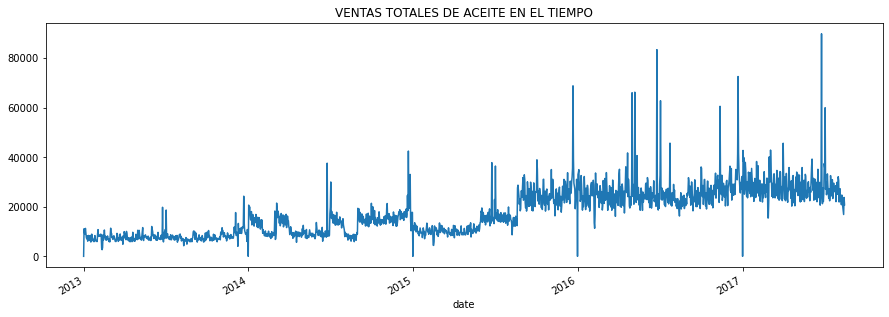

In [38]:
# Visualizamos la serie a través del tiempo
df1.set_index('date').sales.plot(figsize=(15,5), title=f'VENTAS TOTALES DE ACEITE EN EL TIEMPO')

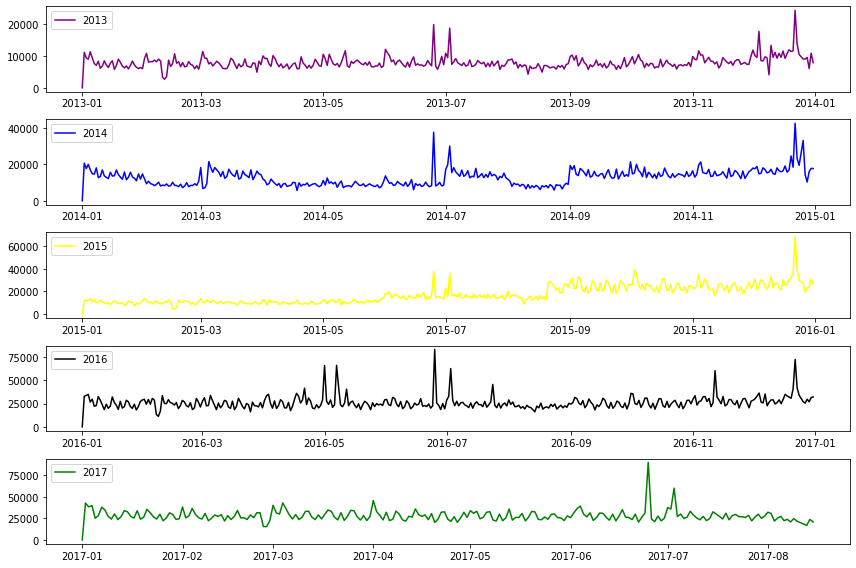

In [39]:
# Podemos visualizar la serie por años
fig, ax = plt.subplots(5,1, figsize=(12,8))
ax[0].plot(df1.set_index('date').sales[df1.set_index('date').index < '2014-01-01'], label='2013', color='purple')
ax[0].legend(loc='upper left')
ax[1].plot(df1.set_index('date').sales[(df1.set_index('date').index >= '2014-01-01') &\
                                      (df1.set_index('date').index < '2015-01-01')], label='2014', color='blue')
ax[1].legend(loc='upper left')
ax[2].plot(df1.set_index('date').sales[(df1.set_index('date').index >= '2015-01-01') &\
                                      (df1.set_index('date').index < '2016-01-01')], label='2015', color='yellow')
ax[2].legend(loc='upper left')
ax[3].plot(df1.set_index('date').sales[(df1.set_index('date').index >= '2016-01-01') &\
                                      (df1.set_index('date').index < '2017-01-01')], label='2016', color='black')
ax[3].legend(loc='upper left')
ax[4].plot(df1.set_index('date').sales[df1.set_index('date').index >= '2017-01-01'], label='2017', color='green')
ax[4].legend(loc='upper left')
plt.tight_layout()
plt.show()

#### Descomposición de la serie

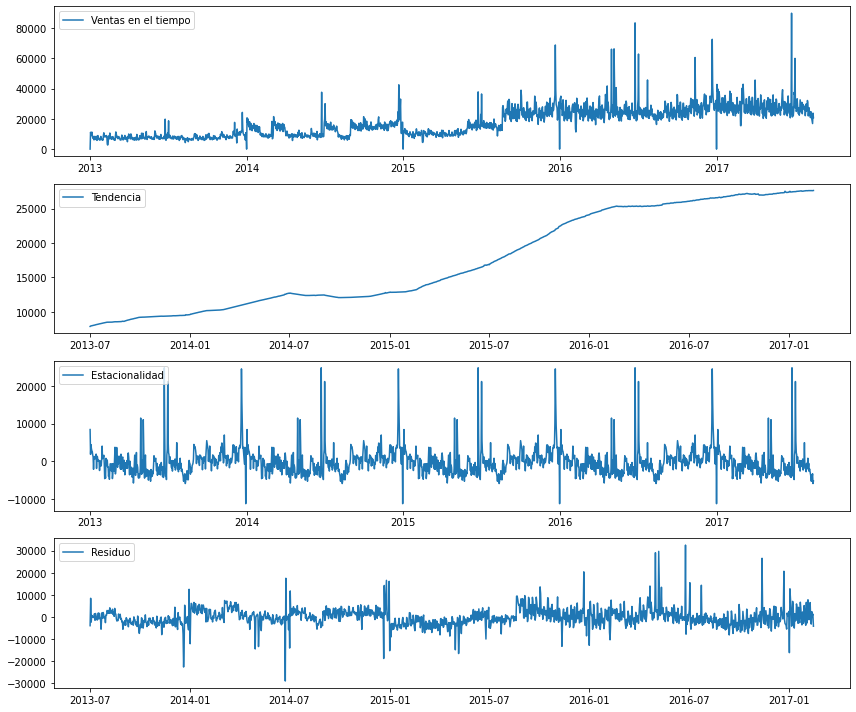

In [40]:
# Tendencia
trend = sm.tsa.seasonal_decompose(df1.set_index('date')['sales'], model='additive', period=365).trend

# Estacionalidad
seasonal = sm.tsa.seasonal_decompose(df1.set_index('date')['sales'], model='additive', period=365).seasonal

# Residuos
resid = sm.tsa.seasonal_decompose(df1.set_index('date')['sales'], model='additive', period=365).resid

# Graficamos
fig, ax = plt.subplots(4,1, figsize=(12,10))
ax[0].plot(df1.set_index('date')['sales'], label='Ventas en el tiempo')
ax[0].legend(loc='upper left')
ax[1].plot(trend, label='Tendencia')
ax[1].legend(loc='upper left')
ax[2].plot(seasonal, label='Estacionalidad')
ax[2].legend(loc='upper left')
ax[3].plot(resid, label='Residuo')
ax[3].legend(loc='upper left')
plt.tight_layout()
plt.show()

# Se podría aplicar también la función seasonal_decompose y se obtiene todo a la vez. Es lo mismo

#### Autocorrelación y estacionareidad

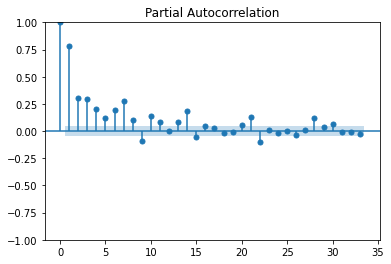

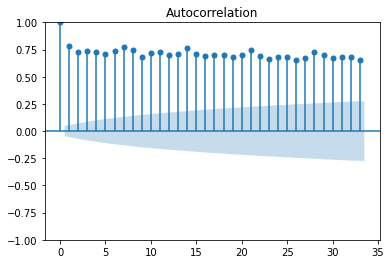

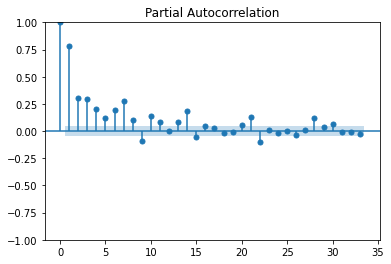

In [41]:
# ACF y PACF (se pueden utilizar para sleccionar los parámetros de los modelos ARIMA)
plot_acf(df1.sales)
plot_pacf(df1.sales)

In [42]:
# Test de Dickey Fuller (Para comprobar la estacionariedad)
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df1.sales)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

# Si el p-valor es menor que 0.05, es estacionaria

ADF test statistic: -1.8610347331350388
ADF p-values: 0.3506076415092784
ADF number of lags used: 21
ADF number of observations: 1662
ADF critical values: {'1%': -3.4342906911169404, '5%': -2.8632805908715726, '10%': -2.5676966486957706}
ADF best information criterion: 32846.41706914157


In [43]:
# Tenemos que diferenciarla para que sea estacionaria
df1['new_sales'] = df1.sales.diff()
df1 = df1.dropna()
df1.head()

,date,sales,new_sales
1,2013-01-02,11111.838999,11111.838999
2,2013-01-03,9335.661000,-1776.177999
3,2013-01-04,8954.490010,-381.170990
4,2013-01-05,11268.065000,2313.574990
5,2013-01-06,9288.223000,-1979.842000


In [44]:
# Volvemos a aplicar la prueba de Dickey-Fuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df1.new_sales)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -12.565015972002097
ADF p-values: 2.0626123803245212e-23
ADF number of lags used: 20
ADF number of observations: 1662
ADF critical values: {'1%': -3.4342906911169404, '5%': -2.8632805908715726, '10%': -2.5676966486957706}
ADF best information criterion: 32829.195414077665


In [45]:
# Creamos columnas de mes y día de la semana
df1['month'] = df1['date'].apply(lambda x: x.strftime('%B'))
df1['week_day'] = df1['date'].dt.day_name()

df1

,date,sales,new_sales,month,week_day
1,2013-01-02,11111.838999,11111.838999,January,Wednesday
2,2013-01-03,9335.661000,-1776.177999,January,Thursday
3,2013-01-04,8954.490010,-381.170990,January,Friday
4,2013-01-05,11268.065000,2313.574990,January,Saturday
5,2013-01-06,9288.223000,-1979.842000,January,Sunday
...,...,...,...,...,...
1679,2017-08-11,20019.100004,-1735.464001,August,Friday
1680,2017-08-12,18452.548990,-1566.551014,August,Saturday
1681,2017-08-13,16867.120000,-1585.428990,August,Sunday
1682,2017-08-14,23754.288999,6887.168999,August,Monday


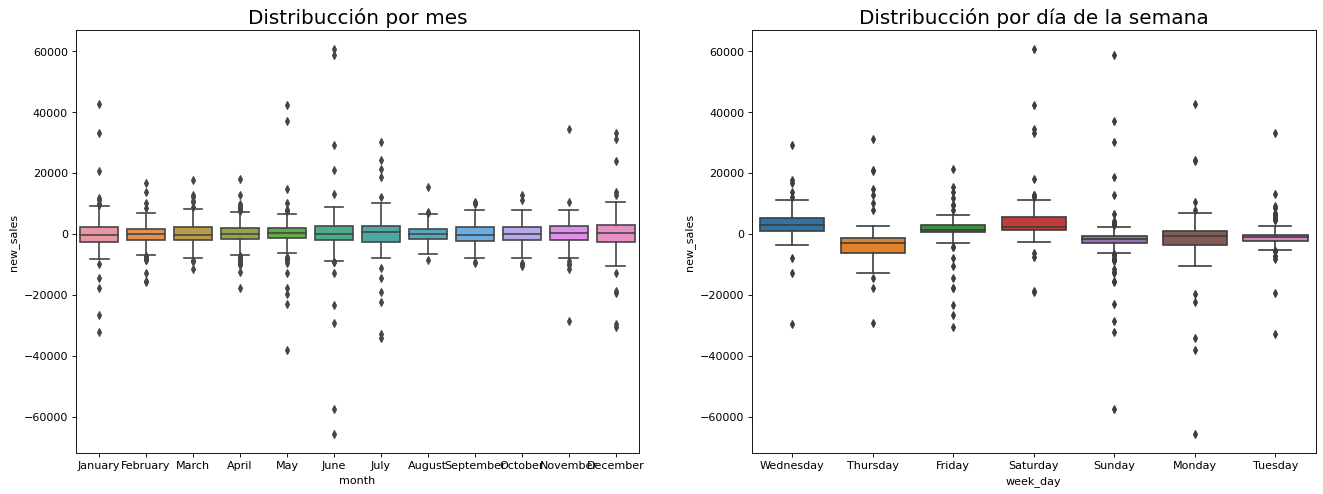

In [46]:
# Visualizamos la distribucción de las ventas por mes y día de la semana
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x=df1.month, y=df1.new_sales, data=df1, ax=axes[0])
sns.boxplot(x=df1.week_day, y=df1.new_sales, data=df1, ax=axes[1])


axes[0].set_title('Distribucción por mes', fontsize=18); 
axes[1].set_title('Distribucción por día de la semana', fontsize=18)
plt.show()

In [47]:
# Estos outliers van a 'molestar' a la hora de modelar, por lo que vamos a cambiar sus valores por las medias de esos meses

# Media de cada mes
monthly_means = df1.groupby('month')['sales'].mean()

# Obtener el bigote superior para cada mes
boxplot_stats = df1.groupby('month')['sales'].describe()['75%']
upper_whisker = boxplot_stats + 1.5 * (boxplot_stats - df1.groupby('month')['sales'].describe()['25%'])

# Crear una máscara que seleccione los valores atípicos
mask = df1.sales > upper_whisker[df1.month.values].values

# Reemplazar los valores atípicos con la media del mes
df1.sales[mask] = df1.groupby('month')['sales'].transform('mean')

# Hemos buscado el valor del bigote superior para coger todos los outliers 
# Límite inferior del bigote = Q1 - 1.5 * RI
# Límite superior del bigote = Q3 + 1.5 * RI


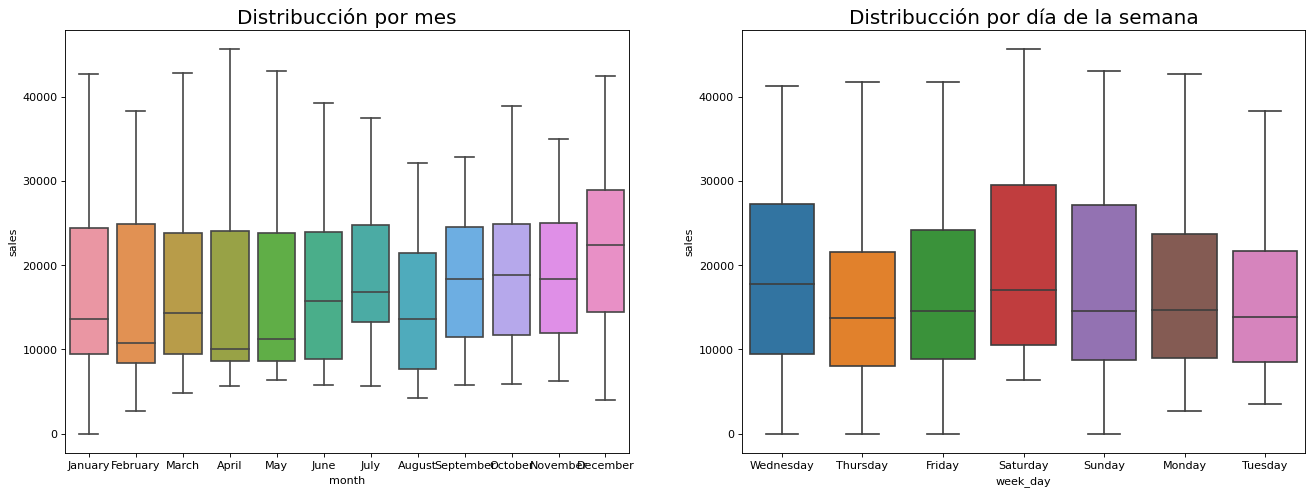

In [48]:
# Visualizamos la distribucción de las ventas por mes y día de la semana después de quitar los valores atípicos
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x=df1.month, y=df1.sales, data=df1, ax=axes[0])
sns.boxplot(x=df1.week_day, y=df1.sales, data=df1, ax=axes[1])


axes[0].set_title('Distribucción por mes', fontsize=18); 
axes[1].set_title('Distribucción por día de la semana', fontsize=18)
plt.show()

In [49]:
# Vamos a añadir como variables ventanas temporales (medias móviles) para usarlas a la hora de predecir
df1 = df1.reset_index(drop=True)
df1['Wind_1day'] = df1.new_sales.rolling(2).mean().reset_index(0,drop=True)
df1['Wind_7day'] = df1.new_sales.rolling(8).mean().reset_index(0,drop=True)
df1['Wind_14day'] = df1.new_sales.rolling(15).mean().reset_index(0,drop=True)
df1['Wind_21day'] = df1.new_sales.rolling(22).mean().reset_index(0,drop=True)
df1['Wind_month'] = df1.new_sales.rolling(31).mean().reset_index(0,drop=True)
# Las siguientes son medias móviles del mismo día que estás mirando pero de las semanas anteriores
# Última semana
df1['last_week_avg'] = df1.groupby('week_day')['sales'].rolling(window=7).mean().reset_index(0, drop=True)
# Últimas dos semanas
df1['two_week_avg'] = df1.groupby('week_day')['sales'].rolling(window=14).mean().reset_index(0, drop=True)
# Últimas tres semanas
df1['three_week_avg'] = df1.groupby('week_day')['sales'].rolling(window=21).mean().reset_index(0, drop=True)

In [50]:
# Eliminamos las primeras filas para quitarnos los nulos y no tener problemas con los modelos. 
# Al ser pocos datos no van a afectarnos mucho
df1.dropna(inplace=True)
df1.head()

,date,sales,new_sales,month,week_day,Wind_1day,Wind_7day,Wind_14day,Wind_21day,Wind_month,last_week_avg,two_week_avg,three_week_avg
140,2013-05-22,7879.839000,677.689000,May,Wednesday,194.271005,188.667625,52.624533,52.061137,5.083225,8074.751429,7838.671642,8002.935952
141,2013-05-23,7048.464000,-831.375000,May,Thursday,-76.843000,-150.957625,-36.993933,-156.951955,-1.275387,6938.004857,6816.647069,6823.170523
142,2013-05-24,8154.633000,1106.169000,May,Friday,137.397000,64.271124,108.809133,-40.470000,65.291806,7300.406570,7110.823646,7378.276096
143,2013-05-25,6604.253004,-1550.379996,May,Saturday,-222.105498,-208.429999,-84.675866,-17.303183,-14.238968,8782.874145,9001.509428,9180.918572
144,2013-05-26,6490.659980,-113.593024,May,Sunday,-831.986510,-273.523503,-213.227068,-181.594637,11.571677,8078.367857,8059.110000,7776.306667


In [51]:
# Antes de entrenar los modelos, vamos a hacer dummies en las columnas categóricas ya que la mayoría de los modelos
# solo admiten numéricas
df1_dummies = pd.concat([df1, pd.get_dummies(df1[['month','week_day']])], axis=1)
df1_dummies.drop(columns=['month','week_day'], inplace = True)
df1_dummies.head()

,date,sales,new_sales,Wind_1day,Wind_7day,Wind_14day,Wind_21day,Wind_month,last_week_avg,two_week_avg,...,month_November,month_October,month_September,week_day_Friday,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday
140,2013-05-22,7879.839000,677.689000,194.271005,188.667625,52.624533,52.061137,5.083225,8074.751429,7838.671642,...,0,0,0,0,0,0,0,0,0,1
141,2013-05-23,7048.464000,-831.375000,-76.843000,-150.957625,-36.993933,-156.951955,-1.275387,6938.004857,6816.647069,...,0,0,0,0,0,0,0,1,0,0
142,2013-05-24,8154.633000,1106.169000,137.397000,64.271124,108.809133,-40.470000,65.291806,7300.406570,7110.823646,...,0,0,0,1,0,0,0,0,0,0
143,2013-05-25,6604.253004,-1550.379996,-222.105498,-208.429999,-84.675866,-17.303183,-14.238968,8782.874145,9001.509428,...,0,0,0,0,0,1,0,0,0,0
144,2013-05-26,6490.659980,-113.593024,-831.986510,-273.523503,-213.227068,-181.594637,11.571677,8078.367857,8059.110000,...,0,0,0,0,0,0,1,0,0,0


In [52]:
# Vamos a separar los datos de entrenamiento y test de tal manera que lo que vamos a predecir sea el último año y creamos
# una columna para facilitarnos la separación
df1_dummies['set'] = ['train' if x <= datetime(2017,1,1) else 'test' for x in df1_dummies.date]

df1_dummies.set_index('date', drop=True, inplace=True)
df1_dummies.index.name = None

X_train1_dummies = df1_dummies[df1_dummies.set == 'train'].drop(columns=['sales','set','new_sales'])
X_test1_dummies =df1_dummies[df1_dummies.set == 'test'].drop(columns=['sales','set','new_sales'])
y_train1_dummies = df1_dummies[df1_dummies.set == 'train'].new_sales
y_test1_dummies = df1_dummies[df1_dummies.set == 'test'].new_sales

### Material utilizado en los modelos

In [53]:
# Vamos a generar un df con los resultados de los distintos modelos para compararlos
# Lo generamos antes de elegir el cluster por si elegimos distintos en la misma ejecucción que se guarden todos
results = pd.DataFrame(columns = ['Model', 'Cluster', 'MAE', 'MAPE', 'MSE', 'RMSE', 'R2 Score'])

## MODELAJE

### Modelos

In [54]:
def linear_regression(X_train, y_train, X_test, y_test):
    # Entrenamos el modelo
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
            
    # Graficar los datos de prueba y el pronóstico
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Datos de prueba')
    plt.plot(X_test.index, y_pred_lr, label='Pronóstico Regresión lineal')
    plt.title('Pronóstico Regresión lineal')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()
    
    return y_pred_lr

def linear_regression_normalize(X_train, y_train, X_test, y_test):
    # Entrenamos el modelo y normalizamos las variables de entrada
    lr = LinearRegression(normalize=True)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
            
    # Graficar los datos de prueba y el pronóstico
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Datos de prueba')
    plt.plot(X_test.index, y_pred_lr, label='Pronóstico Regresión lineal')
    plt.title('Pronóstico Regresión lineal con variables de entrada normalizadas')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()
    
    return y_pred_lr

def random_forest(X_train, y_train, X_test, y_test):
    # Entrenamos el modelo
    rf = RandomForestRegressor(random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
            
    # Graficar los datos de prueba y el pronóstico
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Datos de prueba')
    plt.plot(X_test.index, y_pred_rf, label='Pronóstico Random Forest')
    plt.title('Pronóstico Random Forest')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()
    
    return y_pred_rf

def random_forest_ntrees(X_train, y_train, X_test, y_test):
    # Entrenamos el modelo y seleccionamos el número de árboles en el bosque y la profundidad max de cada árbol
    # Cuántos más árboles más se ajustaría el modelo
    rf = RandomForestRegressor(random_state=0, n_estimators = 20, max_depth = 5)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
        
    # Graficar los datos de prueba y el pronóstico
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Datos de prueba')
    plt.plot(X_test.index, y_pred_rf, label='Pronóstico Random Forest')
    plt.title('Pronóstico Random Forest con elección del número de árboles y su profundidad')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()
    
    return y_pred_rf

def xgboost(X_train, y_train, X_test, y_test):
    # Entrenamos el modelo
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
        
    # Graficar los datos de prueba y el pronóstico
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Datos de prueba')
    plt.plot(X_test.index, y_pred_xgb, label='Pronóstico XGB')
    plt.title('Pronóstico XGBoost')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()
    
    return y_pred_xgb


def xgboost_subs(X_train, y_train, X_test, y_test):
    # Entrenar el modelo y elegimos las muestras para entrenar cada árbol. Un valor menor a 1.0 puede hacer que el 
    #modelo sea más robusto al reducir el riesgo de sobreajuste, pero también puede disminuir el rendimiento en algunos 
    #conjuntos de datos.
    xgb = XGBRegressor(subsample = 0.8)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    
    # Graficar los datos de prueba y el pronóstico
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Datos de prueba')
    plt.plot(X_test.index, y_pred_xgb, label='Pronóstico XGB')
    plt.title('Pronóstico XGBoost con muestreo')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()
    
    return y_pred_xgb


def sarima(X_train, y_train, X_test, y_test, order, seasonal_order):
    # Entrenamos y ajustamos el modelo
    # order son las variables (p,d,q) y seasonal_order las variables (P,D,Q,S) del modelo SARIMAX
    sarima = SARIMAX(endog=y_train, order=order, seasonal_order=seasonal_order)
    sarima_fit = sarima.fit()
    y_pred_sarima = sarima_fit.forecast(steps=len(X_test))
    
    # Graficar los datos de prueba y el pronóstico
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Datos de prueba')
    plt.plot(X_test.index, y_pred_sarima, label='Pronóstico SARIMA')
    plt.title('Pronóstico SARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

    return y_pred_sarima

In [55]:
dict_models = {'Regresión lineal': linear_regression, 'Regresión lineal normalizada': linear_regression_normalize, 
               'Random Forest': random_forest, 'Random Forest con nº de árboles' : random_forest_ntrees,
               'XGBoost': xgboost, 'XGBoost con muestreo' : xgboost_subs, 'SARIMA' : sarima}

### Predicción

Para selecionar directamente el modelo y que se ejecute con ese, ejecutamos la siguiente celda

In [257]:
# select_model = input('¿Qué modelo deseas probar? \n Opciones: \n a: Regresión lineal \n b: Regresión lineal normalizada \n')

In [56]:
# if select_model == 'a':
#     model_name = 'Regresión lineal'
# if select_model == 'b':
#     model_name = 'Regresión lineal normalizada'
   

def forecast(df, model_name, X_train, y_train, X_test, y_test, results, order=None, seasonal_order=None):
    model = dict_models[model_name]
    if model_name == 'SARIMA':
        y_pred = model(X_train, y_train, X_test, y_test, order, seasonal_order)
    else:
        y_pred = model(X_train, y_train, X_test, y_test)
    
    #Calculamos algunas de sus métricas
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    
    # Creamos diccionario con métricas del modelo
    model_metrics = {
        'Model': model_name,
        'Cluster' : select_cluster,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'Order' : order,
        'Seasonal order' : seasonal_order
    }
    
    # Agregamos una fila a la tabla de resultados
    results = results.append(model_metrics, ignore_index = True)
    
    return results
    
# Y si queremos cambiar parámetros en los modelos? Otra función distinta?

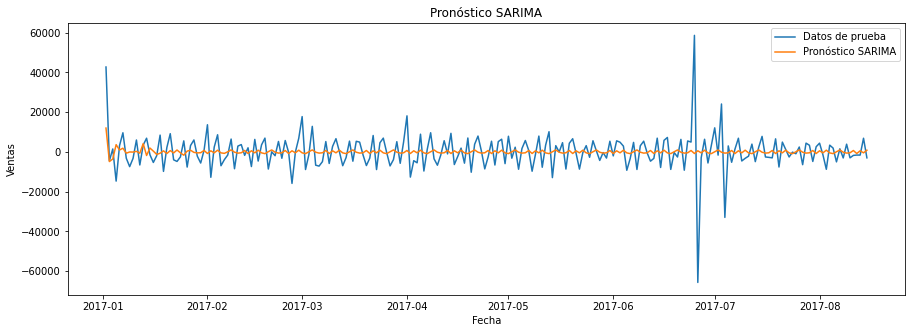

,Model,Cluster,MAE,MAPE,MSE,RMSE,R2 Score,Order,Seasonal order
0,Regresión lineal,2,3419.530613,2.089832,42747543.724379,6538.160577,0.499042,None,None
1,XGBoost con muestreo,2,4050.057632,3.035521,48297767.519625,6949.659525,0.433999,None,None
2,Random Forest con nº de árboles,2,4079.570285,2.051323,48182842.769181,6941.386228,0.435346,None,None
3,SARIMA,2,5908.195048,1.176548,82929116.672826,9106.54252,0.028155,"(1, 1, 1)","(1, 1, 1, 12)"


In [63]:
# En esta linea probamos los distintos modelos y se van guardando
# Importante tener en cuanta que si elegimos el XGB con categóricas hay que meter los datos sin dummies
results = forecast(df1, 'SARIMA', X_train1_dummies, y_train1_dummies, X_test1_dummies, y_test1_dummies,\
                   results, order = (1,1,1), seasonal_order = (1,1,1,12))
results